In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist

In [ ]:
# 1. Wczytanie danych
PATIENT_Z_PATH = 'data/ps3_patient_zet.npy'
GENETIC_DATA_PATH = 'data/ps3_genetic_fingerprints.npy'
X = np.load(GENETIC_DATA_PATH)           # kształt: (N, 512)
patient_z = np.load(PATIENT_Z_PATH).reshape(1, -1)
print(f"Loaded data: {X.shape[0]} patients, {X.shape[1]} genetic features")

Loaded data: 16930 patients, 512 genetic features


Basic feature statistics:
       count      mean       std  min  25%       50%       75%        max
0    16930.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.000000
1    16930.0  0.000038  0.003074  0.0  0.0  0.000000  0.000000   0.355278
2    16930.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.000000
3    16930.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.000000
4    16930.0  0.618274  1.539787  0.0  0.0  0.000000  0.000000   9.512257
..       ...       ...       ...  ...  ...       ...       ...        ...
507  16930.0  2.111789  2.317906  0.0  0.0  1.345241  3.720529  10.994836
508  16930.0  0.000139  0.011858  0.0  0.0  0.000000  0.000000   1.356894
509  16930.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000   0.000000
510  16930.0  0.003623  0.065203  0.0  0.0  0.000000  0.000000   2.431972
511  16930.0  0.001178  0.027627  0.0  0.0  0.000000  0.000000   1.116072

[512 rows x 8 columns]
Pierwsze 5 wierszy danych:
   0    1    2    3         4      

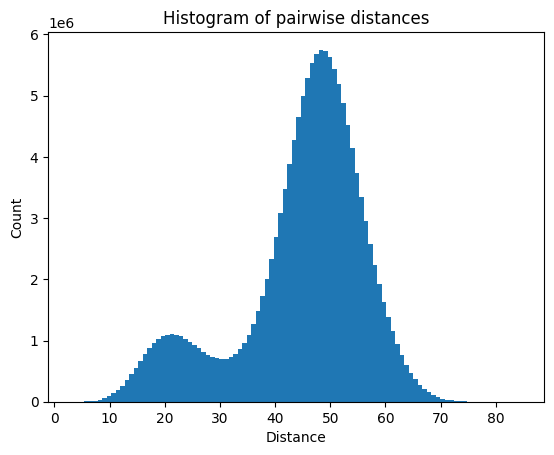

In [10]:
# 2. Eksploracja danych
# Podstawowe statystyki
df = pd.DataFrame(X)
print("Basic feature statistics:")
print(df.describe().T)

print("Pierwsze 5 wierszy danych:")
print(df.head())

# Sprawdzenie braków
drop_counts = df.isnull().sum().sum()
print(f"Total missing values: {drop_counts}")

# Histogram parowych odległości
dists = pdist(X)
plt.hist(dists, bins=100)
plt.title('Histogram of pairwise distances')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.savefig('pairwise_distance_hist.png')
print("Saved 'pairwise_distance_hist.png'")

In [ ]:
# 3. Przygotowanie danych do modelowania
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
z_scaled = scaler.transform(patient_z)

Saved 'elbow_plot.png'
Saved 'silhouette_plot.png'
Optimal number of clusters (best_k): 7


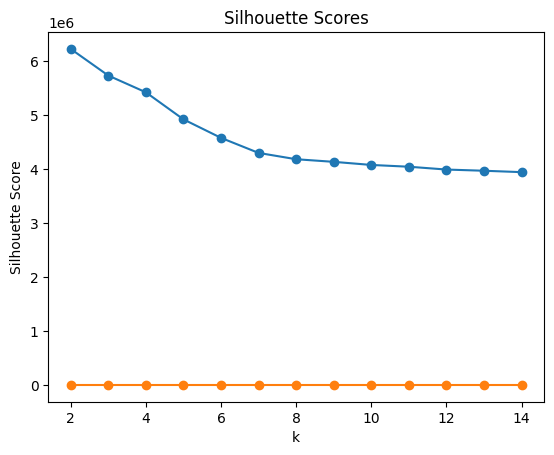

In [5]:
# 4. Wybór optymalnej liczby klastrów
Ks = range(2, 15)
distortions = []
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels_k = km.fit_predict(X_scaled)
    distortions.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels_k))

# Wykres Elbow
iX, = plt.plot(Ks, distortions, 'o-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.savefig('elbow_plot.png')
print("Saved 'elbow_plot.png'")

# Wykres Silhouette
iY, = plt.plot(Ks, sil_scores, 'o-')
plt.title('Silhouette Scores')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.savefig('silhouette_plot.png')
print("Saved 'silhouette_plot.png'")

# Automatyczny wybór k na podstawie max silhouette
best_k = Ks[np.argmax(sil_scores)]
print(f"Optimal number of clusters (best_k): {best_k}")

In [6]:
# 5. Trening finalnego modelu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

Saved 'clusters_pca.png'
Explained variance by PC1+PC2: 17.75%


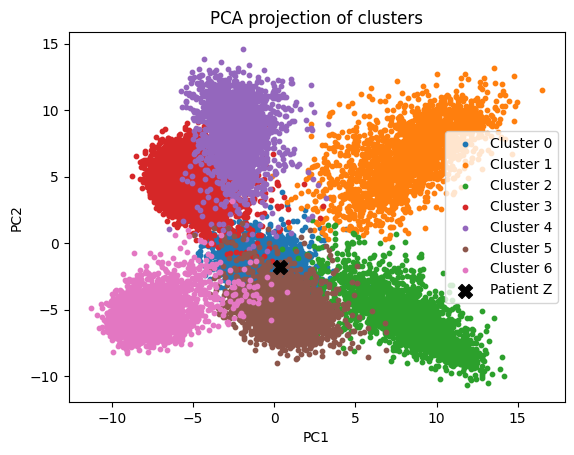

In [7]:
# 6. Redukcja wymiarowości i wizualizacja
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
z_pca = pca.transform(z_scaled)
explained_var = pca.explained_variance_ratio_.sum() * 100

plt.figure()
for cluster in range(best_k):
    idx = labels == cluster
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=10, label=f'Cluster {cluster}')
plt.scatter(z_pca[0,0], z_pca[0,1], color='black', marker='X', s=100, label='Patient Z')
plt.title('PCA projection of clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('clusters_pca.png')
print("Saved 'clusters_pca.png'")
print(f"Explained variance by PC1+PC2: {explained_var:.2f}%")

In [8]:
# 7. Predykcja i liczba podobnych pacjentów
z_label = kmeans.predict(z_scaled)[0]
cluster_members = np.where(labels == z_label)[0]
n_similar = len(cluster_members) - 1  # minus Patient Z
print(f"Patient Z assigned to cluster {z_label}")
print(f"Number of other patients in that cluster: {n_similar}")
np.savetxt('cluster_members.txt', cluster_members, fmt='%d')
print("Saved 'cluster_members.txt'")


Patient Z assigned to cluster 0
Number of other patients in that cluster: 2427
Saved 'cluster_members.txt'


In [9]:
# 8. Detekcja outlierów
dists_to_center = np.min(
    np.linalg.norm(X_scaled[:,None,:] - kmeans.cluster_centers_[None,:,:], axis=2),
    axis=1
)
thresh = np.percentile(dists_to_center, 95)
outliers = np.where(dists_to_center > thresh)[0]
print(f"Outliers detected (distance > 95th percentile = {thresh:.2f}): {len(outliers)} samples")
np.savetxt('outliers_indices.txt', outliers, fmt='%d')
print("Saved 'outliers_indices.txt'")

print("Clustering pipeline completed successfully.")

Outliers detected (distance > 95th percentile = 25.63): 847 samples
Saved 'outliers_indices.txt'
Clustering pipeline completed successfully.


In [13]:
en_cluster = np.loadtxt('cluster_members.txt', dtype=int)

# Buduj submission.csv z pełnym zestawem pacjentów
# Załóżmy, że X ma N próbek, identyfikowanych od 0 do N-1
def create_submission(cluster_ids, total_samples, filename='submission.csv'):
    # Wszystkie ID
    ids = np.arange(total_samples)
    # Flaga predykcji
    preds = np.zeros(total_samples, dtype=int)
    preds[cluster_ids] = 1
    df = pd.DataFrame({'Id': ids, 'Prediction': preds})
    df.to_csv(filename, index=False)
    print(f"Saved '{filename}' with {df.shape[0]} rows (1s: {preds.sum()}, 0s: {total_samples - preds.sum()})")

# Uzyskaj N z oryginalnego zbioru
total_samples = X.shape[0]
create_submission(cluster_members, total_samples)


Saved 'submission.csv' with 16930 rows (1s: 2428, 0s: 14502)


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Load data
X = np.load('ps3_genetic_fingerprints.npy')   # shape: (N, 512)
z = np.load('ps3_patient_zet.npy').reshape(1, -1)

# 2. Scale
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
zs = scaler.transform(z)

# 3. Train KMeans (k=7)
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(Xs)

# 4. PCA for visualization
pca = PCA(n_components=2, random_state=42).fit(Xs)
X2 = pca.transform(Xs)
z2 = pca.transform(zs)
print(f"Explained variance (PC1+PC2): {pca.explained_variance_ratio_.sum():.2%}")

# 5. Assign Patient Z and count “twins”
z_label = kmeans.predict(zs)[0]
members = np.where(labels == z_label)[0]
print(f"Patient Z in cluster {z_label}, number of other patients: {len(members)}")

# 6. Detect outliers (>95th percentile distance to nearest centroid)
d2c = np.min(
    np.linalg.norm(Xs[:, None, :] - kmeans.cluster_centers_[None, :, :], axis=2),
    axis=1
)
th = np.percentile(d2c, 95)
outliers = np.where(d2c > th)[0]
print(f"Outliers: {len(outliers)} samples (threshold = {th:.2f})")

# 7. Save results
np.savetxt('cluster_members.txt', members, fmt='%d')
np.savetxt('outliers_indices.txt', outliers, fmt='%d')
